# L3: Topic Models
### 732A92/TDDE16 Text Mining
Måns Magnusson

The purpose of this lab is to implement the standard Gibbs sampling algorithm for Latent Dirichlet Allocation in Python. You will be supplied starter code, a smaller corpus with State of the Union addresses for the period 1975 to 2000 by paragraph and a list with English stop words. The code is implemented as a class, `LDAGibbs`, where you are expected to replace central parts of the code with your own implementations.

### 1. Sampling

Implement the basic collapsed Gibbs sampling algorithm for Latent Dirichlet Allocation. Use the starter code and add the components that is missing (the sampler part). We use the fact that 

$$p(z_{i}=k)\propto\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\sum^{V}\left(\beta+n_{k,w_{i}}^{(w)}\right)}=\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{V\beta+n_{k}}$$

to simplify computations, where $K$ is the number of topics, $V$ is the vocabulary size and $D$ is the number of documents. $\mathbf{n}^{(d)}$ is a count matrix of size $D\times K$ with the number of topic indicators by document, $d$, and topic $k$, $\mathbf{n}^{(w)}$ is a count matrix of size $K\times V$ with the number of topic indicators by topic, $k$, and word type, $w$. $\mathbf{n}$ is a topic indicator count vector of length $K$ that contain the number of topic indicators in each topic. The detailed algorithm can be found below:

__Data:__ tokenized corpus $\mathbf{w}$, priors $\alpha, \beta$ <br>
__Result:__ topic indicators $\mathbf{z}$

Init topic indicators $\mathbf{z}$ randomly per token<br>
Init topic probability vector $\mathbf{p}$<br>
Init $\mathbf{n}^{w}$, the topic type count matrix of size ($K \times V$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}^{d}$, the document topic count matrix of size ($D \times K$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}$, the topic count vector of length ($K$) with respect to $\mathbf{z}$<br>

for $g \leftarrow 1$ __to__ _num_\__iterations_ __do__<br>
&emsp;&emsp;// Iterate over all tokens<br>
&emsp;&emsp;for $i \leftarrow 1$ __to__ $N$ __do__<br>
&emsp;&emsp;&emsp;&emsp;// Remove current topic indicator $z_i$ from $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ -= 1, $n^{(d)}_{d_i,z_i}$ -= 1, $n_{z_i}$ -= 1<br>
&emsp;&emsp;&emsp;&emsp;for $k \leftarrow 1$ __to__ $K$ __do__<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;// Compute the unnormalized probability of each topic indicator<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathbf{p}_k \leftarrow \left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\left(V\beta+n_{k}\right)}$<br>
&emsp;&emsp;&emsp;&emsp;__end__<br>
&emsp;&emsp;&emsp;&emsp;// Sample the topic indicator<br>
&emsp;&emsp;&emsp;&emsp;$z_i \leftarrow $ Categorical($\mathbf{p}$)<br>
&emsp;&emsp;&emsp;&emsp;// Add the new topic indicator $z_i$ to $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ += 1, $n^{(d)}_{d_i,z_i}$ += 1, $n_{z_i}$ += 1<br>
&emsp;&emsp;__end__<br>
__end__

For a complete derivation of the collapsed Gibbs sampler for LDA, see https://lingpipe.files.wordpress.com/2010/07/lda3.pdf.

In [6]:
import numpy, random, scipy.special
from tm3 import LDAGibbs
import matplotlib.pyplot as plt

class MyGibbs(LDAGibbs):
        
    def __init__(self, num_topics, docs_file_name, stop_list_file_name = None):
        self.num_topics = num_topics
        self.num_docs = 0
        self.docs = []
        ## Prepare set of stop words
        self.stop_words = set()
        if stop_list_file_name != None:
            with open(stop_list_file_name) as f:
                for line in f:
                    word = line.rstrip()
                    self.stop_words.add(word)
        self.read_documents(docs_file_name)
        self.initialize_matrices()
            
    def read_documents(self, filename):
        """Reads documents from a file, filters stop words and initializes
        the vocabulary. Also converts tokens to integer term IDs."""
        self.vocab = []
        self.vocab_ids = {}
        with open(filename) as f:
            for line in f:
                line = line.replace(".", " ").replace(",", " ").lower()
                self.num_docs += 1
                tokens = []
                for w in line.split():
                    if not w in self.stop_words:
                        if w in self.vocab_ids:
                            tokens.append(self.vocab_ids[w])
                        else:
                            term_id = len(self.vocab)
                            self.vocab.append(w)
                            self.vocab_ids[w] = term_id
                            tokens.append(term_id)
                self.docs.append({ 'tokens': tokens })
        self.num_terms = len(self.vocab)
        print("Read {} documents with a total of {} terms".format(self.num_docs, self.num_terms))
        
    def initialize_matrices(self):
        """Initializes numpy arrays for the matrix computations performed
        by the sampler during the MCMC process."""
        ## Set up numpy matrices
        self.term_topics = numpy.zeros((self.num_terms, self.num_topics)) # n^w
        self.doc_topics = numpy.zeros((self.num_docs, self.num_topics)) # n^d
        self.topic_totals = numpy.zeros(self.num_topics) # n
        self.doc_totals = numpy.zeros(self.num_docs)
        self.total_tokens = 0
        ## Initialize topics randomly
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            ## Create an array of random topic assignments
            doc['topics'] = [random.randrange(self.num_topics) for token in doc['tokens']]
            ## Construct the initial summary statistics
            doc_length = len(doc['tokens'])
            for token, topic in zip(doc['tokens'], doc['topics']):
                self.term_topics[token][topic] += 1 # n_wk
                self.doc_topics[doc_id][topic] += 1 # n_dk
                self.topic_totals[topic] += 1       # n_k
                self.doc_totals[doc_id] += 1
                self.total_tokens +=1
        ## Printout to check that everything is coherent
        #print(sum(sum(self.doc_topics)))
        #print(sum(sum(self.term_topics)))
        #print(sum(self.topic_totals))
        #print(sum(self.doc_totals))
        
    def run(self, num_iterations = 50, alpha = 0.1, beta = 0.01):
        self.logprobs = []
        for iteration in range(num_iterations): #iteration = 0
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            print("iteration {}, {}".format(iteration, logprob))
            
    def make_draw(self, alpha, beta):
        ## TODO: implement this function for exercise 1
        
        #super().make_draw(alpha, beta)
        #return        
        
        for i, doc in enumerate(self.docs):
            for j, token in enumerate(doc['tokens']):
                z_i = self.docs[i]['topics'][j]
                self.term_topics[token][z_i] -= 1 # n_wk
                self.doc_topics[i][z_i] -= 1 # n_dk
                self.topic_totals[z_i] -= 1 # n_k
                p = [-1 for _ in range(self.num_topics)]
                for k in range(self.num_topics):
                    a = (alpha+self.doc_topics[i][k])
                    b = ((beta+self.term_topics[token][k]) / (self.num_terms * beta + self.topic_totals[k]))
                    p[k] = a*b
                p = p/numpy.sum(p)
                
                z_i = numpy.random.choice(self.num_topics, size=1, replace=True, p = p)[0]
                self.docs[i]['topics'][j] = z_i
                self.term_topics[token][z_i] += 1 # n_wk
                self.doc_topics[i][z_i] += 1 # n_dk
                self.topic_totals[z_i] += 1 # n_k
            
    def print_topics(self, j):
        ## TODO: implement this function for exercise 2
        #super().print_topics(j)
        #for topic in term_topics:
        topics = [[] for _ in range(10)]

        for term_id, topic_counts in enumerate(self.term_topics):
            for topic_id, topic_count in enumerate(topic_counts):
                topics[topic_id].append((topic_count, term_id))
        
        for topic in topics:
            topic.sort(reverse=True)
            for count, term_id in topic[:10]:
                print(self.vocab[term_id], count, end=", ")
            print("\n")
            
    
    def plot(self,alpha = 0.1, beta = 0.01):
        ## TODO: implement this function for exercise 3
        tolerance = 0.000001
        
        while True: #iteration = 0
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            super().plot()
            print(logprob-(self.logprobs[-2]))
            super().plot()
            if logprob<self.logprobs[-2]+tolerance:
                break
        print(len(self.logprobs))
        
        super().plot()
        
    def plot_only():
        super().plot()
    
    def compute_logprob(self, alpha, beta):
        ## TODO: implement this function for the bonus exercise
        return super().compute_logprob(alpha, beta)

        

Implement the `make_draw` function above. You should get behavior very similar to the results from calling the parent class.

In [7]:
num_topics = 10
num_iterations = 10

model = MyGibbs(num_topics, 'sotu_1975_2000.txt', 'stoplist_en.txt')
model.run(num_iterations)

Read 2899 documents with a total of 8695 terms
iteration 0, -10.37143008335574
iteration 1, -9.846916024889293
iteration 2, -9.577037119839675
iteration 3, -9.421251635276008
iteration 4, -9.311150286494684
iteration 5, -9.227769228656909
iteration 6, -9.156040056016568
iteration 7, -9.097441610441297
iteration 8, -9.046758046160862
iteration 9, -8.995658911486881


### 2. Top terms
Implement the `print_topics` function to extract the top `j` largest counts in $n(w)$ by row. This is the most probable word types in each topic.

In [8]:
model.print_topics(10)

tax 137.0, year 100.0, work 89.0, american 87.0, children 80.0, families 80.0, give 64.0, care 63.0, support 63.0, child 62.0, 

world 111.0, economic 99.0, nations 71.0, security 63.0, rights 61.0, future 55.0, nation 55.0, support 52.0, states 51.0, countries 47.0, 

world 189.0, america 151.0, peace 106.0, freedom 104.0, people 93.0, tonight 91.0, free 70.0, great 67.0, united 65.0, nation 58.0, 

people 214.0, america 128.0, americans 110.0, make 88.0, work 85.0, crime 77.0, time 76.0, security 71.0, future 70.0, congress 66.0, 

program 80.0, year 80.0, energy 76.0, years 76.0, administration 70.0, oil 65.0, budget 61.0, million 60.0, 1980 57.0, spending 53.0, 

congress 67.0, work 59.0, people 56.0, state 53.0, make 52.0, ve 48.0, future 47.0, years 46.0, government 43.0, children 42.0, 

programs 73.0, program 70.0, congress 66.0, system 61.0, energy 55.0, government 54.0, inflation 53.0, major 49.0, education 46.0, policy 46.0, 

america 98.0, health 92.0, congress 87.0, year 8

### 3. Explore the data

Run your implemention on the State of the Union corpus until convergence with 10 topics, don't forget to remove stop words. Plot the log marginal posterior by the number of iterations. How many iterations do you need until convergence? How do you interpret the topics?

[Hint: You can use the plot-function to print the marginal probability for each iteration. To get it working in Jupyter you need to run the command `%matplotlib inline` before plotting the first time.]

0.04421388896492395
0.03440997651955513
0.04631713101542978
0.01992818690571596
0.03433511001341749
0.031563014933107425
0.018766993125209908
0.01964779444893061
0.01605551028500507
0.023429040522813693
0.01658625522123991
0.01255439778718248
0.01906893900033424
0.010536151622847711
0.01550414495393504
0.011582583321960271
0.012055425459125857
0.012098764611341295
0.009868741642073076
0.007835798449109532
0.014413350214617537
-0.0006565938318434661
32


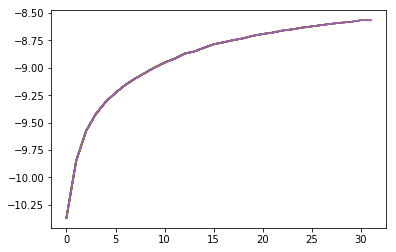

In [9]:
%matplotlib inline
model.plot()

#### Answer here:
We tried a few different methods, but lastly we chose a tolerance of 0.01 for convergence and then the process took 27 iterations.

### 4. Simulate a new State of the Union speech

Write a function `new_speech` using the `MyGibbs` class to use the estimated values for $\Phi$ from your model (with stop words removed) to simulate a new State of the Union speech. Start out by simulating $\theta_d \sim Dir(\alpha = 0.5)$ and then simulate your document. Does it make sense? Why, why not?

In [153]:
def phi(model, beta=0.01):
    phis = numpy.zeros((model.num_topics,model.num_terms))
    
    for topic_id in range(model.num_topics):
        for term_id in range(model.num_terms):
            n_w = model.term_topics[term_id][topic_id]
            phis[topic_id][term_id]=(n_w+beta)/(n_w+beta*model.num_terms)
    return phis

def theta(model, alpha=0.5):
    thetas = numpy.zeros((model.num_docs,model.num_topics))
    
    for doc_id in range(model.num_docs):
        for topic_id in range(model.num_topics):
            n_d = model.doc_topics[doc_id][topic_id]
            thetas[doc_id][topic_id]=(n_d+alpha)/(n_d+alpha*model.num_topics)
    return thetas
            
def new_speech(model, alpha, num_words):
    speech = []
    phis = phi(model)
    thetas = theta(model, alpha)
    
    for doc_id, doc in enumerate(model.docs):
        for term_id in doc['tokens']:
            doc_theta = thetas[doc_id]
            new_topic = numpy.random.choice(model.num_topics, size=1, replace=True, p = doc_theta/numpy.sum(doc_theta))[0]
            word_phi = phis[new_topic]
            new_word = numpy.random.choice(model.num_terms, size=1, replace=True, p = word_phi/numpy.sum(word_phi))[0]
            speech.append(model.vocab[new_word])
            if len(speech)>=num_words:
                break
        if len(speech)>=num_words:
            break
    return " ".join(speech)

In [154]:
new_speech(model, 0.5, 100)

'89 sides rhetoric make globalization workers financial faith sharing laws job sensitive bloc congress gifts pro shores oas great patrol defense parent propose decision emissions stop parties found wildlife communities promise roots foremost ve saps honor egypt savings experienced commitment libyan water cooperation make freedom water fragmented media invite modern narrow investments quality research abroad participate major suggested sino investment troops house average good increased care domination tall cost hall security rule rebuilding heritage industry solve rise global problems town america advantage show convention country yesterday sacred ll continues child expanding partnership people live compliance faith provide mexican tests build'

#### Answer here:
The text does not really make sense, especially without stopwords. You can however see some trends of words that belongs to certain topics.

### Bonus assignment:

To get better understanding how to implement the underlying model or similar models, you might want to implement your own function to compute the log marginal posterior. If so, implement the `compute_logprob` function.

$$\begin{align}
\log p(\mathbf{z}|\mathbf{w}) =& \log\prod^{K}p(\mathbf{w}|\mathbf{z},\beta)\prod^{D}p(\mathbf{z}|\alpha) \\
=& \sum^{K}\log\left[\frac{\Gamma\left(\sum^{V}\beta\right)}{\prod^{V}\Gamma\left(\beta\right)}\frac{\prod^{V}\Gamma\left(n_{kv}^{(w)}+\beta\right)}{\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)}\right]+\sum^{D}\log\left[\frac{\Gamma\left(\sum^{K}\alpha\right)}{\prod^{K}\Gamma\left(\alpha\right)}\frac{\prod^{K}\Gamma\left(n_{dk}^{(d)}+\alpha\right)}{\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)}\right] \\
=& K\log\Gamma\left(V\beta\right)-KV\log\Gamma\left(\beta\right)+\sum^{K}\sum^{V}\log\Gamma\left(n_{kv}^{(w)}+\beta\right)-\sum^{K}\log\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)\\
&+ D\log\Gamma\left(K\alpha\right)-DK\log\Gamma\left(\alpha\right)+\sum^{D}\sum^{K}\log\Gamma\left(n_{dk}^{(d)}+\alpha\right)-\sum^{D}\log\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)
\end{align}$$

In Python, use `scipy.special.gammaln` for $\log\Gamma(x)$ (if you run into problems, you might try `math.lgamma` instead).